In [1]:
from datetime import datetime

import pandas as pd
from energy_box_control.power_hub.control import control_power_hub, initial_control_state
from energy_box_control.power_hub.network import PowerHub, PowerHubSchedules
from energy_box_control.schedules import ConstSchedule

import matplotlib.pylab as plt

%load_ext autoreload 
%autoreload 2

In [2]:
from datetime import timedelta
from energy_box_control.power_hub.control import initial_control_all_off


results = {}
control_results = {}

schedules = PowerHubSchedules(
    global_irradiance_schedule=ConstSchedule(800),
    cooling_demand_schedule=ConstSchedule(100 / 24 / 60 / 60),
)
power_hub = PowerHub.power_hub(schedules)
steps = 500
step_size = 60

control_state = initial_control_state()

state = power_hub.simple_initial_state(datetime.now(), timedelta(seconds=step_size))
control_values = initial_control_all_off(power_hub)
power_hub_sensors = power_hub.sensors_from_state(state)

for _ in range(steps):
    state = power_hub.simulate(state, control_values)
    
    #if state.connection(power_hub.__dict__['cold_reservoir'], BoilerPort.HEAT_EXCHANGE_IN).temperature < 0:

    sensors = power_hub.sensors_from_state(state)
    control_state, control_values = control_power_hub(
        power_hub, control_state, sensors, state.time
    )
    # control_values = no_control(power_hub)

    control_results[state.time.timestamp] = pd.DataFrame(
        {**{
            key: item.__dict__
            for key, item in control_values.name_to_control_values_mapping(
                power_hub
            ).items()
        },**{'control_mode':{key: item.control_mode._value_ for key, item in control_state.__dict__.items() if key != 'setpoints'}}}
    ).T.stack()
    results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()

control_data = pd.DataFrame(control_results).T[1::]
data = pd.DataFrame(results).T[1::]

In [126]:
#test for powers summing to 0 and come up with convention for sign 

#test consistency of flows

#implement real schedules 

In [3]:
appliances = ["heat_pipes", "hot_reservoir", "pcm", "yazaki", "chiller", "preheat_reservoir", "outboard_exchange", "cold_reservoir"]
temperatures = [(appliance,var) for appliance, var in data.columns if 'temperature' in var and appliance in appliances]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances]
flows = [(appliance,var) for appliance, var in data.columns if 'flow' in var and appliance in appliances]

In [4]:
data[powers]

chiller cold_reservoir               \
                           chill_power exchange_power   fill_power   
2024-04-23 11:16:43.006261         0.0            0.0          0.0   
2024-04-23 11:17:43.006261         0.0           -0.0    -0.001064   
2024-04-23 11:18:43.006261    -10000.0   -9255.319235  -744.681922   
2024-04-23 11:19:43.006261    -10000.0   -9255.319235  -744.681922   
2024-04-23 11:20:43.006261    -10000.0   -9255.319235  -744.681922   
...                                ...            ...          ...   
2024-04-23 19:30:43.006261         0.0           -0.0    -0.001064   
2024-04-23 19:31:43.006261         0.0           -0.0    -0.001064   
2024-04-23 19:32:43.006261         0.0  -13102.321558 -1054.210845   
2024-04-23 19:33:43.006261         0.0  -14848.544958 -1194.711578   
2024-04-23 19:34:43.006261         0.0  -10649.256415  -856.837787   

                             heat_pipes  hot_reservoir             \
                                  power exchange_power fill_power   
2024-04-23 11:16:43.006261          0.0            0.0        0.0   
2024-04-23 11:17:43.006261     10001.68            0.0        0.0   
2024-04-23 11:18:43.006261  9857.984791            0.0        0.0   
2024-04-23 11:19:43.006261  9817.324946            0.0        0.0   
2024-04-23 11:20:43.006261  9813.817287            0.0        0.0   
...                                 ...            ...        ...   
2024-04-23 19:30:43.006261  7654.156354            0.0        0.0   
2024-04-23 19:31:43.006261  7636.361534            0.0        0.0   
2024-04-23 19:32:43.006261  7618.571251            0.0        0.0   
2024-04-23 19:33:43.006261  7600.785755            0.0        0.0   
2024-04-23 19:34:43.006261   7687.32302            0.0        0.0   

                                               outboard_exchange          pcm  \
                           total_heating_power             power charge_power   
2024-04-23 11:16:43.006261                -0.0               0.0          0.0   
2024-04-23 11:17:43.006261                -0.0               0.0  8547.838323   
2024-04-23 11:18:43.006261                -0.0               0.0  9719.083305   
2024-04-23 11:19:43.006261                -0.0               0.0  9757.420719   
2024-04-23 11:20:43.006261                -0.0               0.0  9267.307022   
...                                        ...               ...          ...   
2024-04-23 19:30:43.006261                -0.0               0.0  7227.912936   
2024-04-23 19:31:43.006261                -0.0               0.0  7211.109071   
2024-04-23 19:32:43.006261                -0.0               0.0  9643.801064   
2024-04-23 19:33:43.006261                -0.0               0.0  8074.507493   
2024-04-23 19:34:43.006261                -0.0               0.0  8842.417522   

                                           preheat_reservoir        yazaki  \
                           discharge_power    exchange_power   chill_power   
2024-04-23 11:16:43.006261             0.0               0.0           0.0   
2024-04-23 11:17:43.006261             0.0               0.0           0.0   
2024-04-23 11:18:43.006261             0.0           -5000.0           0.0   
2024-04-23 11:19:43.006261             0.0           -5018.0           0.0   
2024-04-23 11:20:43.006261             0.0           -5018.0           0.0   
...                                    ...               ...           ...   
2024-04-23 19:30:43.006261             0.0              -0.0           0.0   
2024-04-23 19:31:43.006261             0.0             -72.0           0.0   
2024-04-23 19:32:43.006261    43779.812857     -13989.668875 -14156.531246   
2024-04-23 19:33:43.006261    21992.390225     -18098.798261 -16043.255379   
2024-04-23 19:34:43.006261    31116.102437     -24363.287009 -11506.093045   

                                                        
                              used_power   waste_power  
2024-04-23 11:16:43.006261           0.

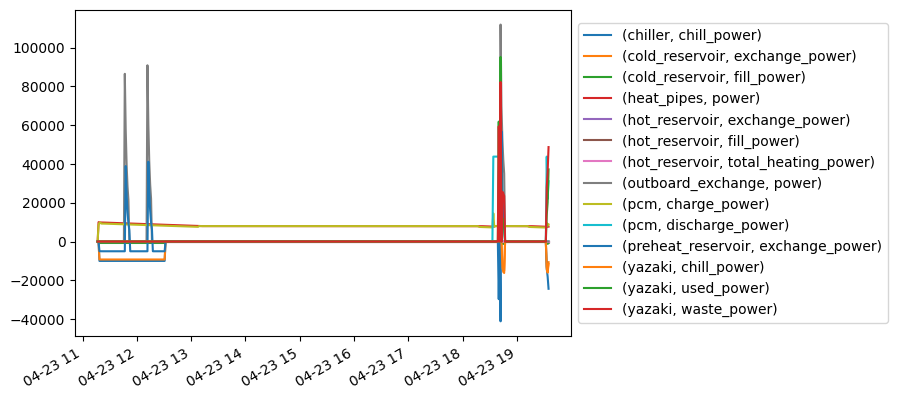

In [5]:
data[powers].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

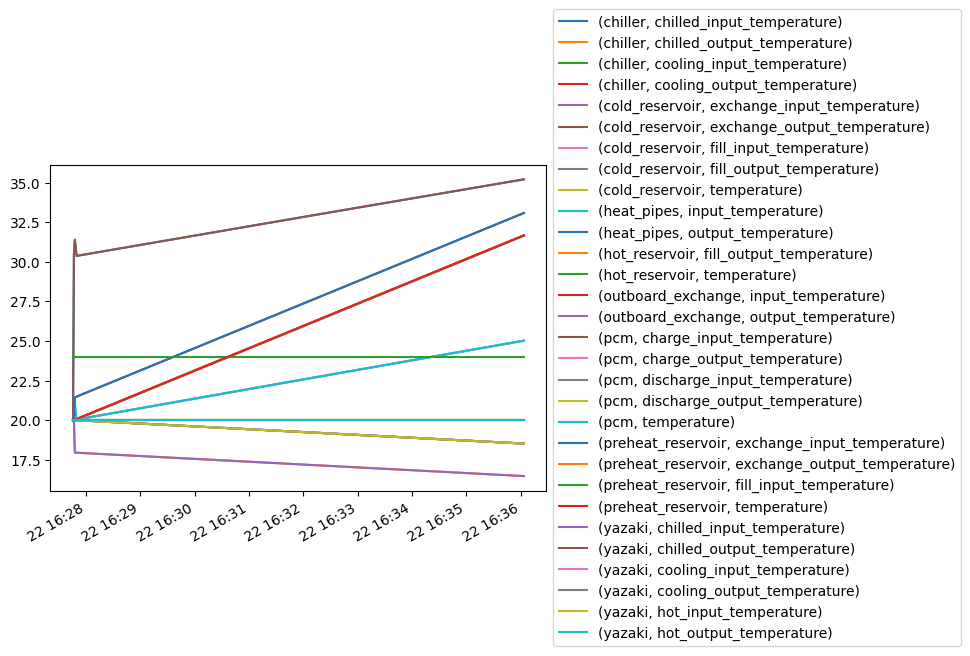

In [69]:
data[temperatures].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))